In [1]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
import numpy as np

from utils.plots import visualize_vehicle_trajectories
from utils.loader import load_data_from_database
from utils.transformer import categirze_ids

In [2]:
print("Do you want to load data from the database? This may take a while.")
if input("Type 'y' to proceed: ").lower() == 'y':
    df = load_data_from_database()
    df = df.sort_values(['date_time', 'frame_id'])
else:
    df = pd.read_csv("raw_traffic_data.csv", parse_dates=['date_time'])
    df = df.sort_values(['date_time', 'frame_id'])

Do you want to load data from the database? This may take a while.


In [3]:
df

,id,vehicle_id,area,x,y,width,heigth,date_time,frame_id
8985936,1,0,2280.5,133,0,47.0,63.0,2025-11-26 18:29:00.525059,3
8985935,2,1,893.0,0,0,48.0,20.0,2025-11-26 18:29:38.086927,833
8985934,3,1,882.0,0,0,50.0,19.0,2025-11-26 18:29:38.124244,834
8985933,4,1,931.0,0,0,50.0,20.0,2025-11-26 18:29:38.160491,835
8985932,5,1,817.0,11,0,44.0,20.0,2025-11-26 18:29:38.195794,836
...,...,...,...,...,...,...,...,...,...
4,8985933,527,2753.0,19,244,73.0,46.0,2025-12-26 15:38:30.802531,110222
3,8985934,527,2698.0,21,251,72.0,39.0,2025-12-26 15:38:30.836873,110223
2,8985935,527,2240.0,26,254,65.0,36.0,2025-12-26 15:38:30.870364,110224
1,8985936,527,2170.0,27,254,63.0,36.0,2025-12-26 15:38:30.903506,110225


In [4]:
df['session_id'] = (
    (df['frame_id'].diff() < 0)
).cumsum()

In [5]:
df.groupby('session_id').count()

,id,vehicle_id,area,x,y,width,heigth,date_time,frame_id
session_id,,,,,,,,,
0,28090,28090,28090,28090,28090,28090,28090,28090,28090
1,15936,15936,15936,15936,15936,15936,15936,15936,15936
2,8238814,8238814,8238814,8238814,8238814,8238814,8238814,8238814,8238814
3,33537,33537,33537,33537,33537,33537,33537,33537,33537
4,7082,7082,7082,7082,7082,7082,7082,7082,7082
5,10582,10582,10582,10582,10582,10582,10582,10582,10582
6,8504,8504,8504,8504,8504,8504,8504,8504,8504
7,17186,17186,17186,17186,17186,17186,17186,17186,17186
8,30834,30834,30834,30834,30834,30834,30834,30834,30834


In [6]:
# 1. Select one stable session and sort
session_id_to_analyze = 0
session_df = df[df['session_id'] == session_id_to_analyze].sort_values(['vehicle_id', 'date_time'])

# Filter vehicle_id with less than 20 records
vehicle_counts = session_df['vehicle_id'].value_counts()
valid_vehicles = vehicle_counts[vehicle_counts >= 20].index
session_df = session_df[session_df['vehicle_id'].isin(valid_vehicles)]


In [7]:
session_df

,id,vehicle_id,area,x,y,width,heigth,date_time,frame_id,session_id
8985920,17,9,869.5,63,0,29.0,45.0,2025-11-26 18:29:46.476043,1071,0
8985919,18,9,989.0,63,0,24.0,44.0,2025-11-26 18:29:46.508871,1072,0
8985918,19,9,3212.0,31,0,63.0,57.0,2025-11-26 18:29:46.541822,1073,0
8985917,20,9,2137.0,31,0,62.0,60.0,2025-11-26 18:29:46.574465,1074,0
8985916,21,9,2052.5,32,0,61.0,60.0,2025-11-26 18:29:46.608348,1075,0
...,...,...,...,...,...,...,...,...,...,...
8957851,28086,2646,1592.5,100,237,33.0,53.0,2025-11-26 19:28:50.406232,101949,0
8957850,28087,2646,1348.0,101,243,32.0,47.0,2025-11-26 19:28:50.440216,101950,0
8957849,28088,2646,1210.5,102,246,31.0,44.0,2025-11-26 19:28:50.485293,101951,0
8957848,28089,2646,1042.0,103,250,30.0,40.0,2025-11-26 19:28:50.523095,101952,0


In [8]:
final_summary = categirze_ids(session_df)

In [9]:
final_summary

,session_id,vehicle_id,y_start,y_end,w_mean,w_std,frames_count,t_start,t_end,x_mean,path_completeness,size_cv,category
0,0,9,0,64,63.166667,9.575421,54,2025-11-26 18:29:46.476043,2025-11-26 18:29:48.386354,51.796296,0.220690,0.151590,Unclassified/RelayCandidate
1,0,11,0,66,42.516129,6.082055,31,2025-11-26 18:29:48.312889,2025-11-26 18:29:49.443239,59.741935,0.227586,0.143053,Unclassified/RelayCandidate
2,0,12,129,145,80.269231,6.606407,26,2025-11-26 18:29:48.434170,2025-11-26 18:29:49.361263,48.153846,0.055172,0.082303,Unclassified/RelayCandidate
3,0,15,70,174,67.428571,12.633951,42,2025-11-26 18:29:49.491033,2025-11-26 18:29:50.957720,30.761905,0.358621,0.187368,Partial
4,0,35,145,258,29.500000,7.259177,24,2025-11-26 18:29:54.649710,2025-11-26 18:29:55.441529,22.416667,0.389655,0.246074,Partial
...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,0,2603,196,54,40.671875,2.532673,64,2025-11-26 19:27:57.044337,2025-11-26 19:27:59.257807,145.593750,0.489655,0.062271,Partial
337,0,2604,51,16,37.100000,1.333772,20,2025-11-26 19:27:59.319870,2025-11-26 19:28:00.009714,150.750000,0.120690,0.035951,Unclassified/RelayCandidate
338,0,2608,18,16,29.666667,2.575526,21,2025-11-26 19:28:01.115844,2025-11-26 19:28:01.820339,149.619048,0.006897,0.086815,Unclassified/RelayCandidate
339,0,2640,0,69,43.586957,11.870318,92,2025-11-26 19:28:45.336458,2025-11-26 19:28:48.496042,53.565217,0.237931,0.272336,Unclassified/RelayCandidate


In [10]:
final_summary.groupby('category').agg('size')

category
Flickering                       5
Partial                        125
Perfect                         21
Unclassified/RelayCandidate    190
dtype: int64

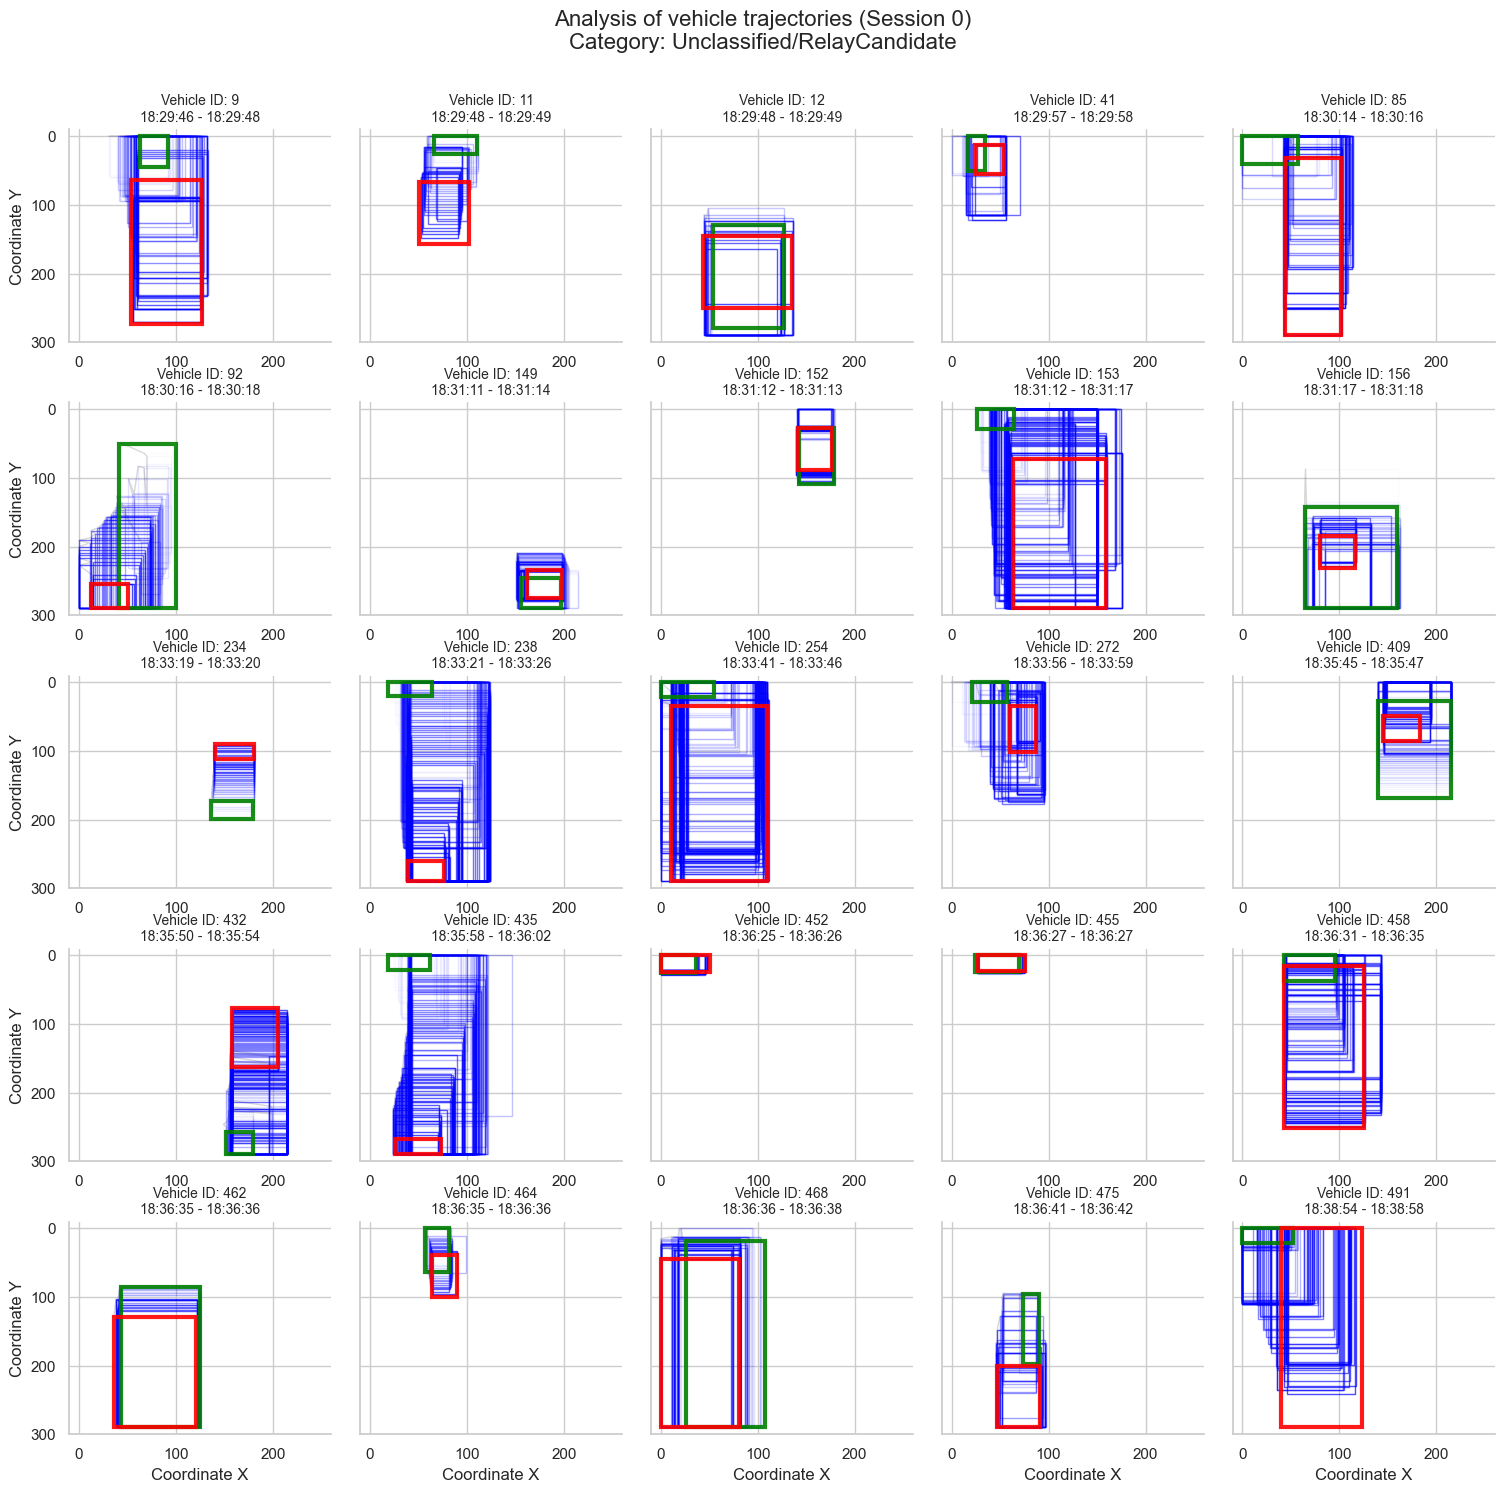

In [11]:
ids_to_plot = final_summary[final_summary['category'] == 'Unclassified/RelayCandidate']['vehicle_id']
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=0, max_vehicles=25, min_records=20, category='Unclassified/RelayCandidate')

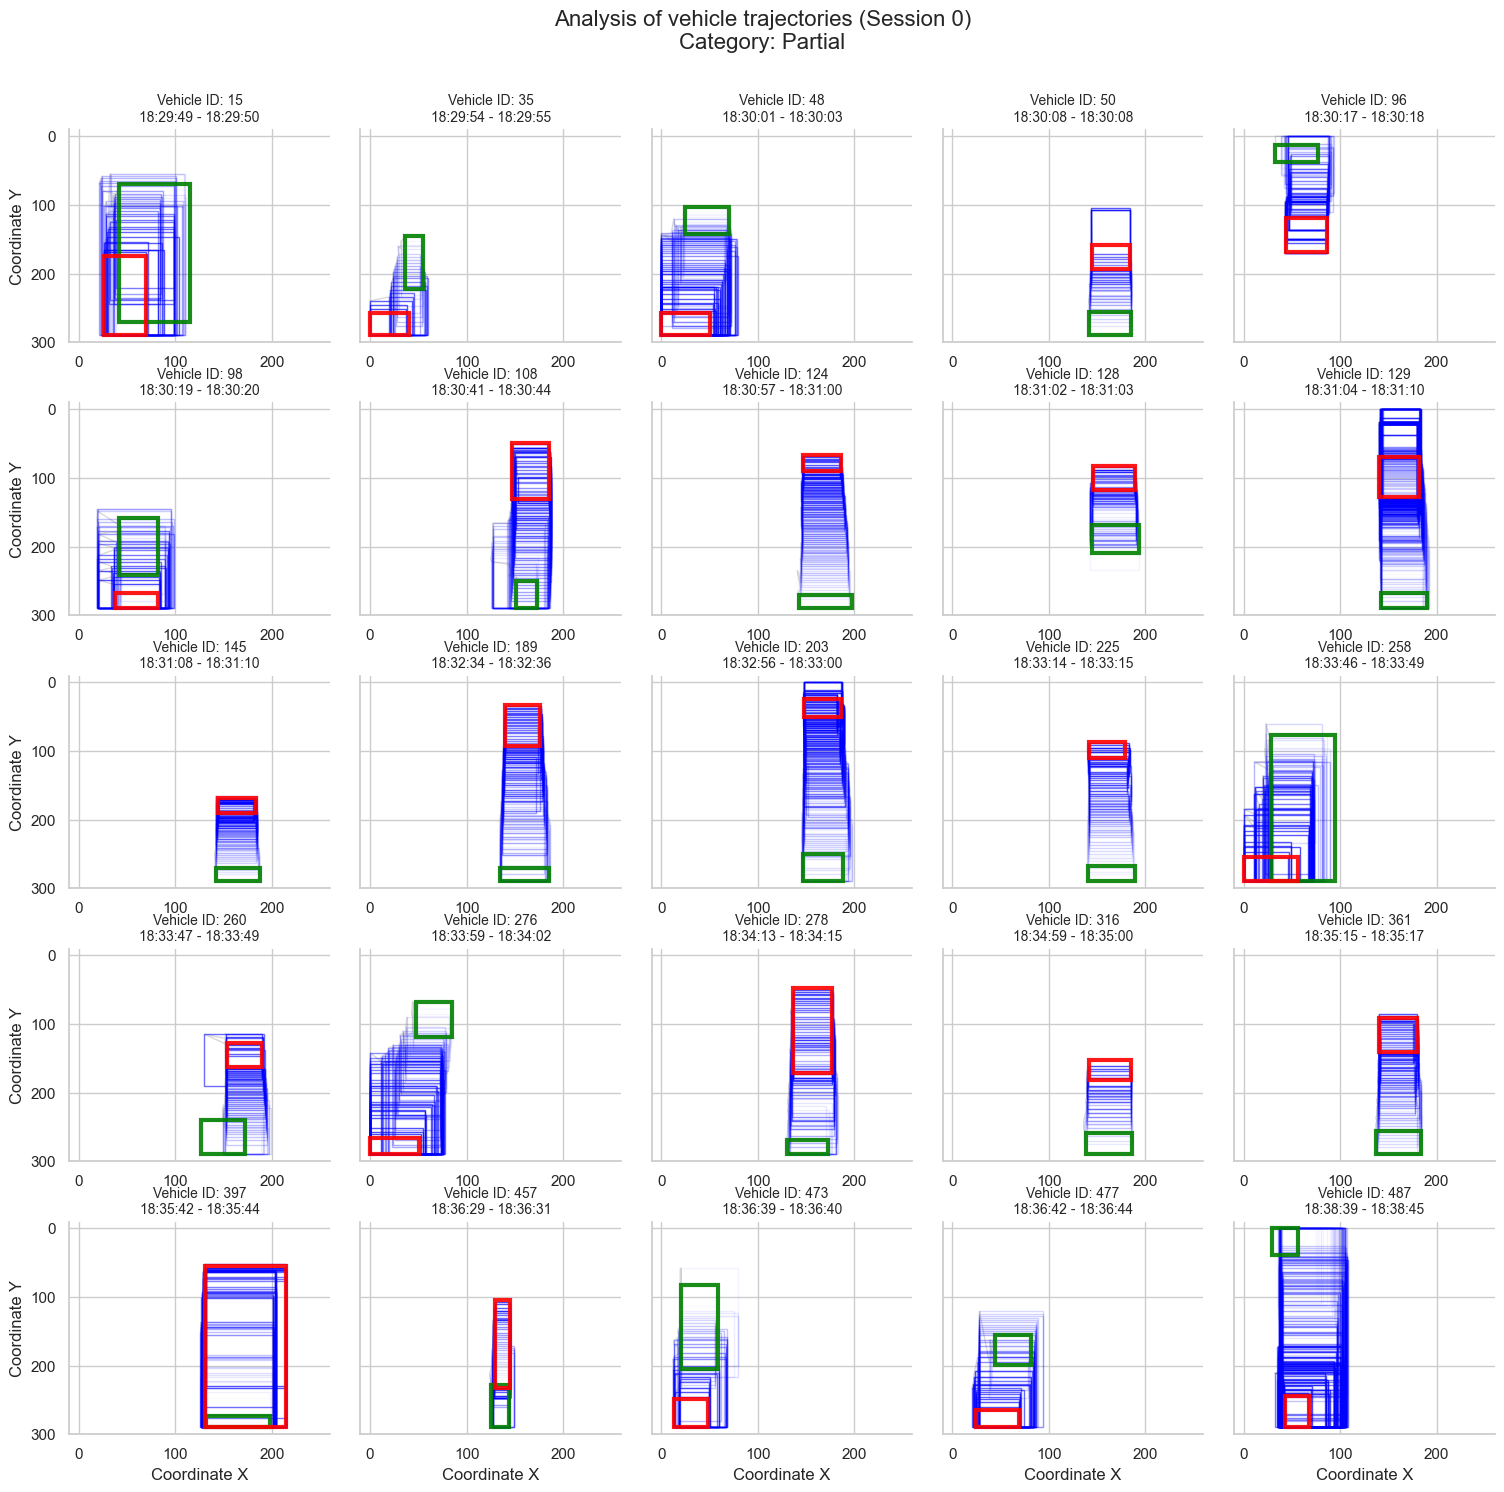

In [12]:
ids_to_plot = final_summary[final_summary['category'] == 'Partial']['vehicle_id']
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=0, max_vehicles=25, min_records=20, category='Partial')

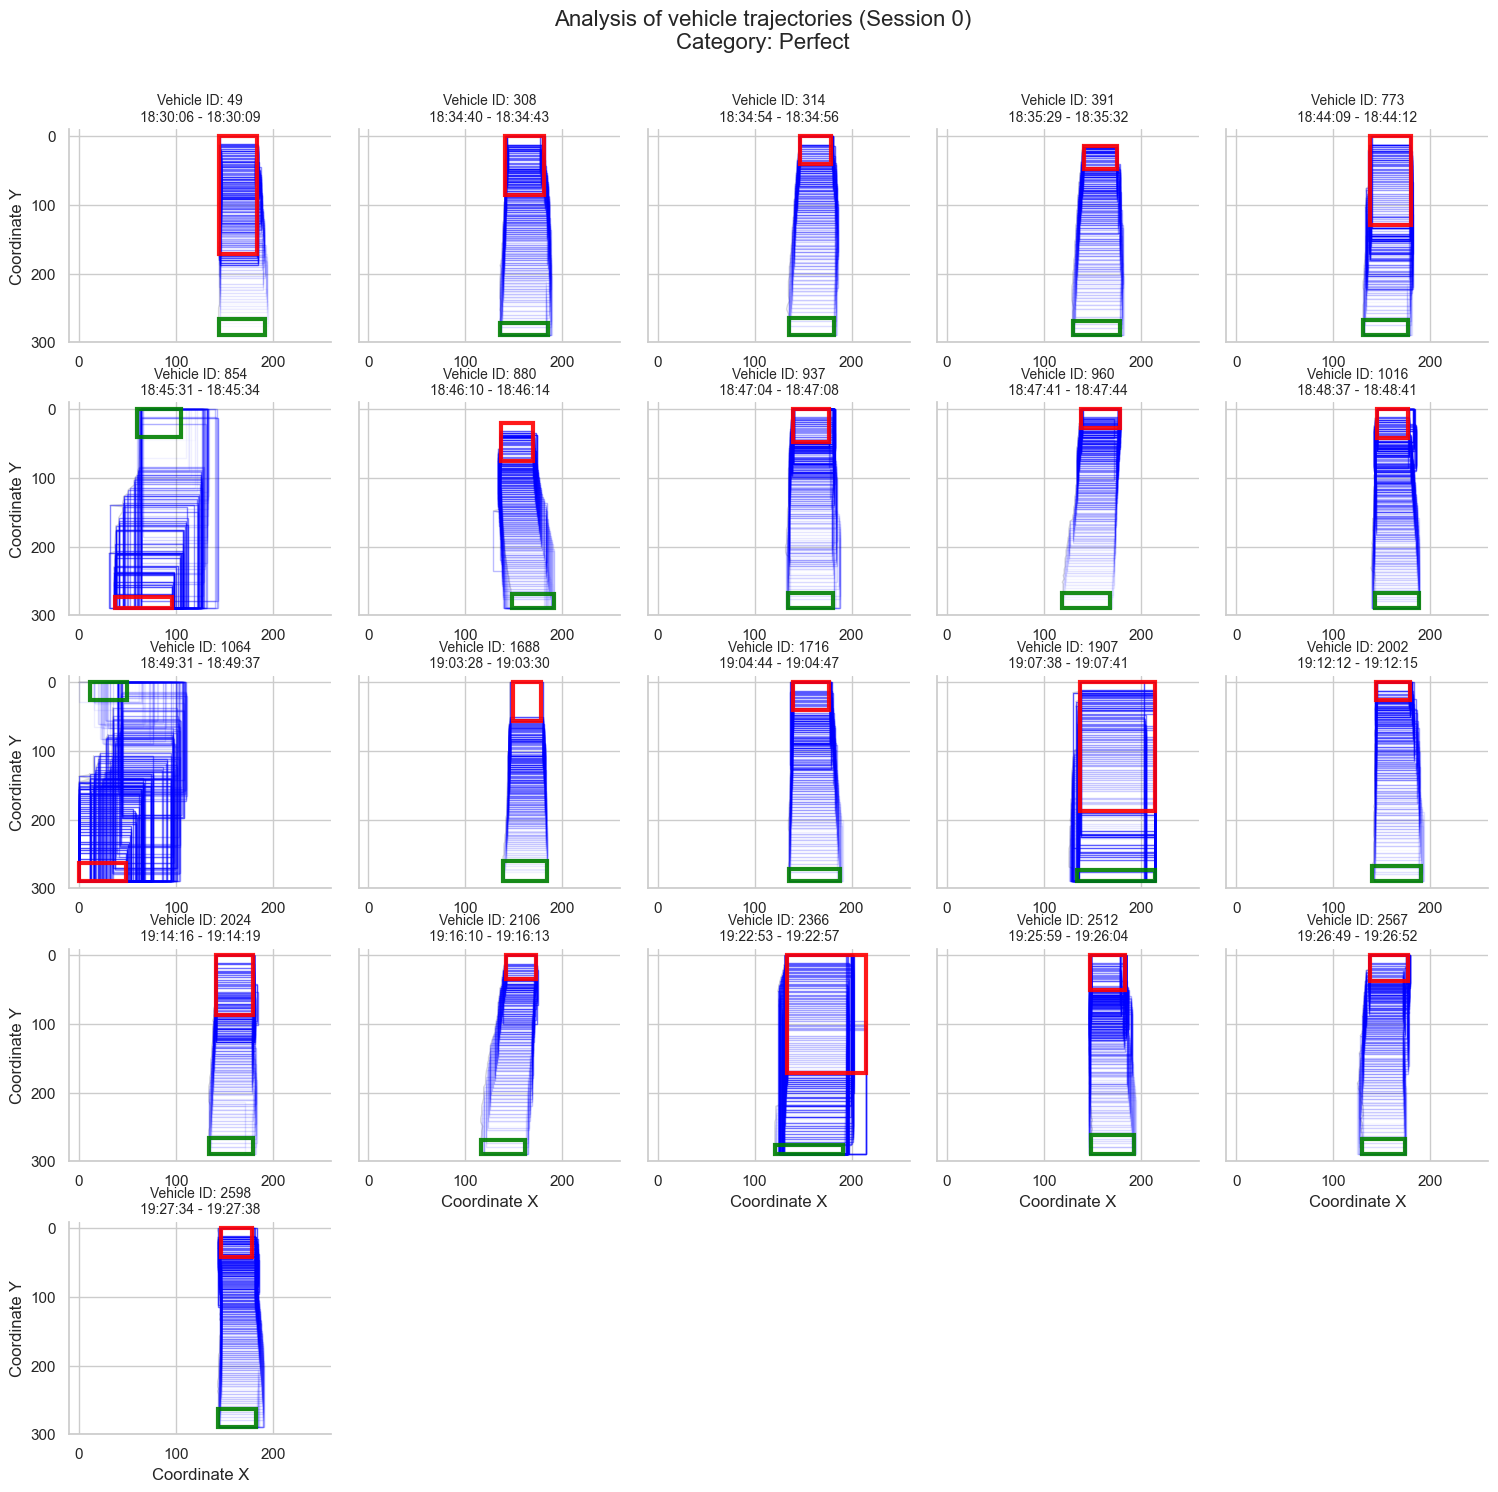

In [13]:
ids_to_plot = final_summary[final_summary['category'] == 'Perfect']['vehicle_id']
plot_data = session_df[session_df['vehicle_id'].isin(ids_to_plot)]
visualize_vehicle_trajectories(plot_data, session_id=0, max_vehicles=25, min_records=20, category='Perfect')

In [14]:
# df['year'] = df['date_time'].dt.year
# df['month'] = df['date_time'].dt.month
# df['day'] = df['date_time'].dt.day
# df['hour'] = df['date_time'].dt.hour
# df['unique_vehicle_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df['unique_frame_id'] = round(df['vehicle_id'] + df['year']/10000 + df['month']/1000000 + df['day']/100000000 + df['hour']/10000000000, 10)
# df.head()

In [15]:
# df['size'] = df['width'] * df['heigth']
# df.head()

In [16]:
# min_max_df = df.groupby('unique_vehicle_id')[['size', 'y']].agg(['max', 'min']).sort_index()

In [17]:
# min_max_df['way_size'] = min_max_df['y']['max'] - min_max_df['y']['min']
# min_max_df.columns = ['size_max', 'size_min', 'y_max', 'y_min', 'way_size']
# min_max_df.head()

In [18]:
# min_max_df['full_way'] = min_max_df['way_size'] > 240

In [19]:
# min_max_df['day'] = min_max_df.index.map(lambda x: True if 6 <= int((x* 10000000000)%100) < 18 else False)

In [20]:
# min_max_df